Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
# Installing Augmentor library
!pip install Augmentor

In [ ]:
# Import all necessary libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import seaborn as sns
import Augmentor
from glob import glob

In [ ]:
# Connect to google drive for accessing data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/CNNAssignment/SkinCancerDetection/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/CNNAssignment/SkinCancerDetection/Test')

In [ ]:
# Lets count the training and test set images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
# Defining batch size, image height and image width to be used through out the notebook
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# Function to load datasets
# Using 80% of the images for training, and 20% for validation.
def load_datasets(data_dir_train,data_dir_test):
  train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  batch_size = batch_size,
  image_size = (img_height, img_width)
  )

  val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = "validation",
    batch_size = batch_size,
    image_size = (img_height, img_width)
  )
  class_names = train_ds.class_names
  num_classes = len(class_names)
  AUTOTUNE = tf.data.experimental.AUTOTUNE
  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
  return (train_ds, val_ds, class_names,num_classes)

In [ ]:
# Load dataset
train_ds, val_ds, class_names,num_classes = load_datasets(data_dir_train,data_dir_test)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# Common function to visualize performance during training

def visualize_history(history,epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

### Visualize the data
#### create a code to visualize one instance of all the nine classes present in the dataset

In [ ]:
# Function to plot sample images
# Visualize one instance of all the nine classes present in the dataset
def plot_sample_images(ds,class_names):
  plt.figure(figsize=(10, 10))
  remaining_lbllist = range(0,9)
  j = 0
  for images, labels in ds:
    labelsList = labels.numpy()
    lstToPrint = list(set(labelsList).intersection(remaining_lbllist))
    for i in lstToPrint:
      arrIndices = np.where(labelsList == i)
      ax = plt.subplot(3, 3, j + 1)
      plt.imshow(images[arrIndices[0][0]].numpy().astype("uint8"))
      plt.title(class_names[labelsList[arrIndices[0][0]]])
      plt.axis("off")
      j = j + 1
    remaining_lbllist = list(set(remaining_lbllist) - set(lstToPrint))
    if len(remaining_lbllist) == 0:
      break
  plt.show()


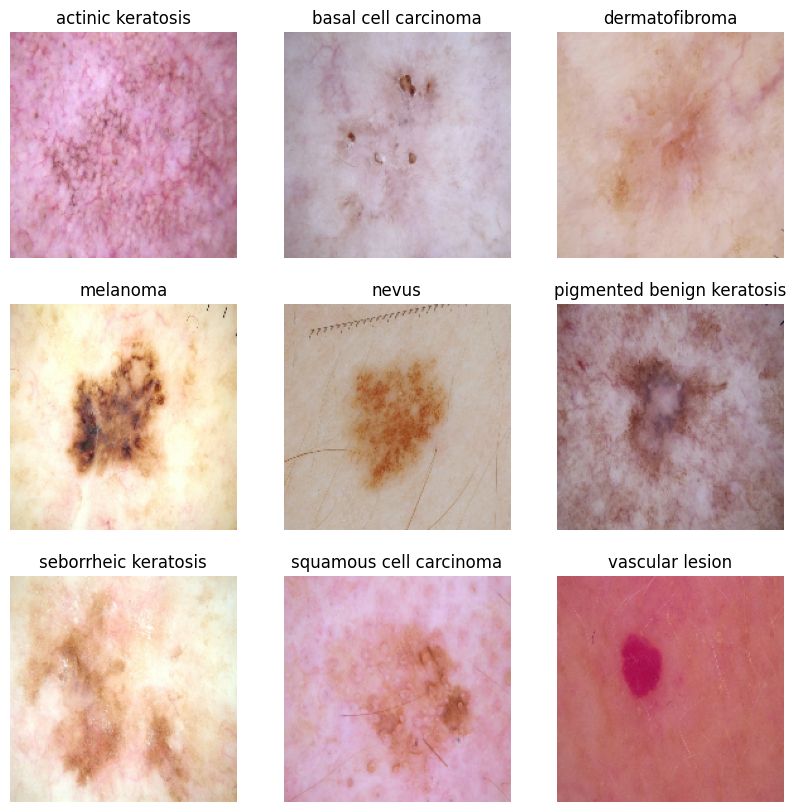

In [ ]:
plot_sample_images(train_ds,class_names)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
# First attempt to create model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32,(3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Conv2D(64,(3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Conv2D(128,(3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
- Since this is image classification problem, best optimizer is adam and loss function chosen is sparse_categorical_crossentropy

In [ ]:
# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │      15,859,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,955,529 (60.87 MB)

 Trainable params: 15,955,529 (60.87 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
# Lets fit the model with 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.1737 - loss: 2.5745 - val_accuracy: 0.3087 - val_loss: 1.9513
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.3277 - loss: 1.8828 - val_accuracy: 0.3937 - val_loss: 1.6658
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.4377 - loss: 1.5982 - val_accuracy: 0.4452 - val_loss: 1.5431
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.4929 - loss: 1.4999 - val_accuracy: 0.5011 - val_loss: 1.4900
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.5064 - loss: 1.3690 - val_accuracy: 0.5391 - val_loss: 1.3592
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.5689 - loss: 1.2211 - val_accuracy: 0.5257 - val_loss: 1.4139
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.5826 - loss: 1.1601 - val_accuracy: 0.5123 - val_loss: 1.3736
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.6463 - loss: 1.0191 - val_accuracy: 0.5168 - v

### Visualizing training results

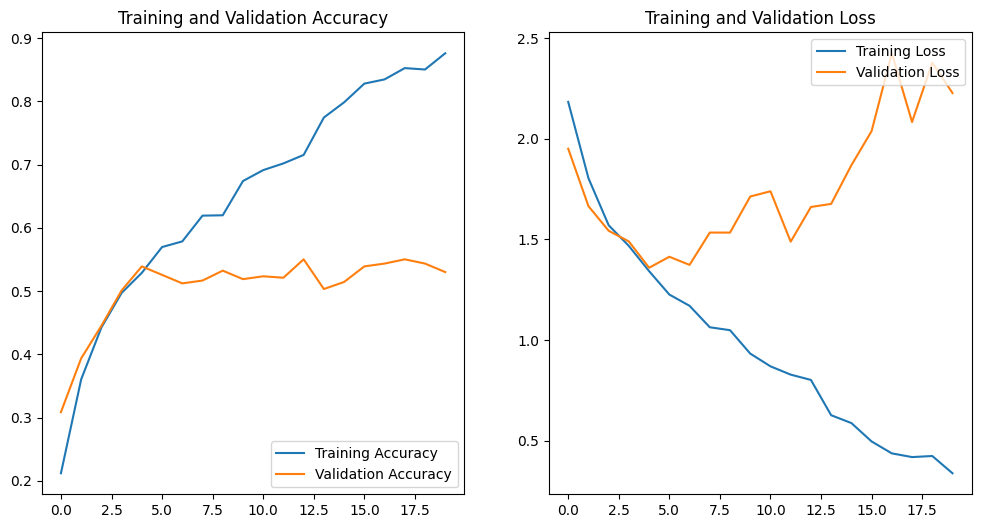

In [ ]:
# Visualize training performance
visualize_history(history,epochs)

### Observation
- Training accuracy increased with each iteration upto 0.87 but validation accuracy remained at max range of 0.5 to 0.55.
- Training loss gradually decreased with each iteration, but validation loss gradually increased.
- This is clear indication that our model has learned the underlying noise along with the data patterns. Hence this is the evidence of overfitting.

### Solution
- Following techninques may help us to prevent overfitting
  - Reducing model complexity (number of layers, number of neurons)
  - Applying regularization (Dropout layers)
  - Batch Normalization
  - Data Augmentation

Now lets try applying these techniques

### Data Augmentation Strategy

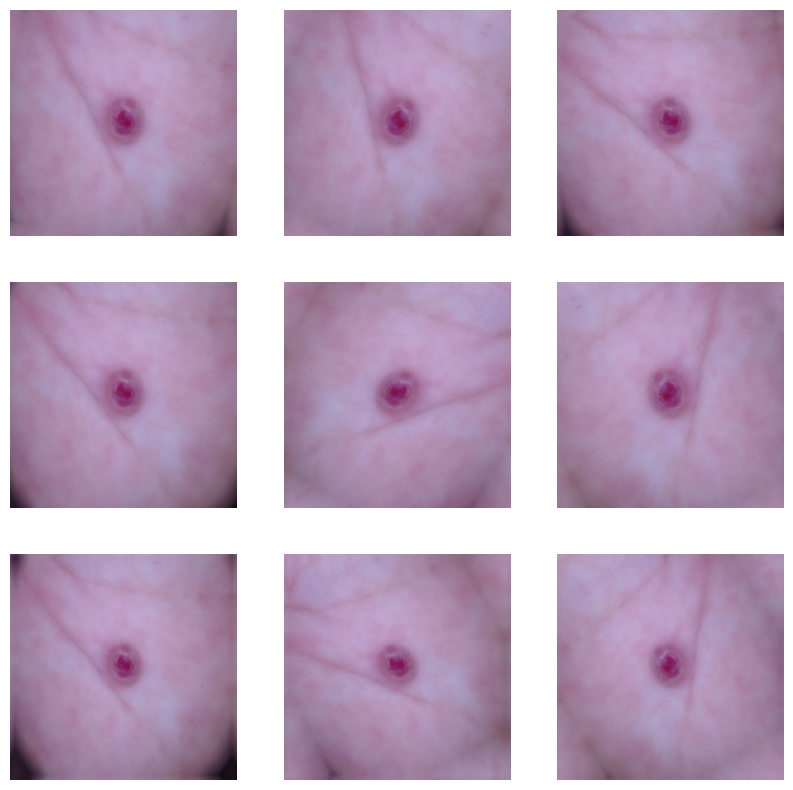

In [ ]:
# Create an augmentation strategy (random rotation & random zoom of the image)
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
# Visualize augmented image for one sample
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Create a model With reduced layers, reduced neurons, data augmentation layer and dropout layer to get rid of overfitting
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Conv2D(16,(3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Conv2D(32,(3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])


### Compiling the model
- Since this is image classification problem, best optimizer is adam and loss function chosen is sparse_categorical_crossentropy

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 64800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │       8,294,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,300,777 (31.66 MB)

 Trainable params: 8,300,777 (31.66 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [ ]:
## Training the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.2505 - loss: 2.3951 - val_accuracy: 0.4698 - val_loss: 1.5909
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.4808 - loss: 1.5576 - val_accuracy: 0.4922 - val_loss: 1.5037
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4931 - loss: 1.4582 - val_accuracy: 0.4944 - val_loss: 1.4394
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4904 - loss: 1.4205 - val_accuracy: 0.5414 - val_loss: 1.3792
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5444 - loss: 1.3565 - val_accuracy: 0.5123 - val_loss: 1.4463
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5704 - loss: 1.2463 - val_accuracy: 0.5526 - val_loss: 1.3588
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5550 - loss: 1.2683 - val_accuracy: 0.5570 - val_loss: 1.3000
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5746 - loss: 1.2033 - val_accuracy: 0.5168 - val_loss:

### Visualizing the results

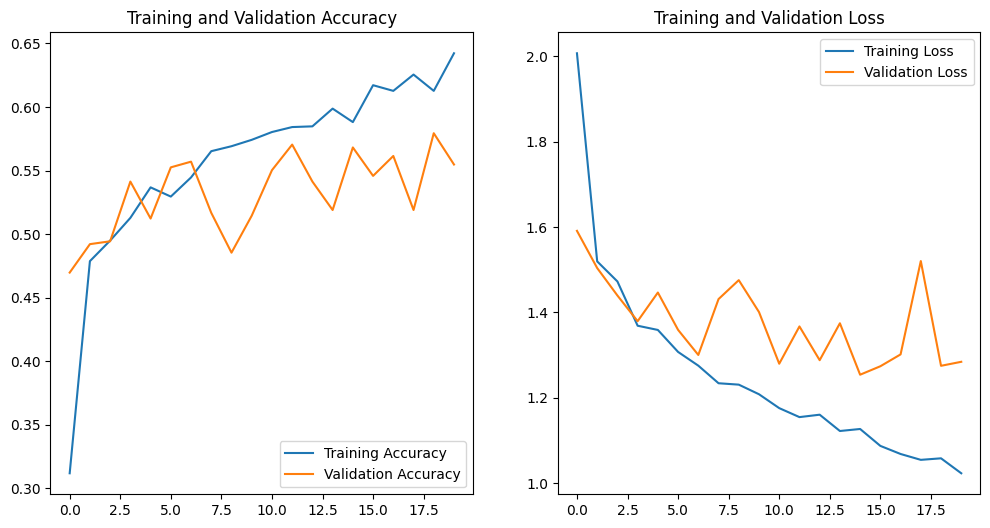

In [ ]:
# Visualize the training results
visualize_history(history,epochs)

- In this attempt following steps are taken to improve model performance and prevent overfitting
  - Reduced number of convolutional layers
  - Reduced number of neurons per layers
  - Added Dropout layer
  - Data augmentation is performed on input

- With this change, difference between training and validation accuracy is reduced. Training accuracy is evaluated near to 64% and validation accuracy is around 55%

- Difference between training and validation loss is reduced

- However Training accuracy of 64% suggest the underfitting.


#### Find the distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

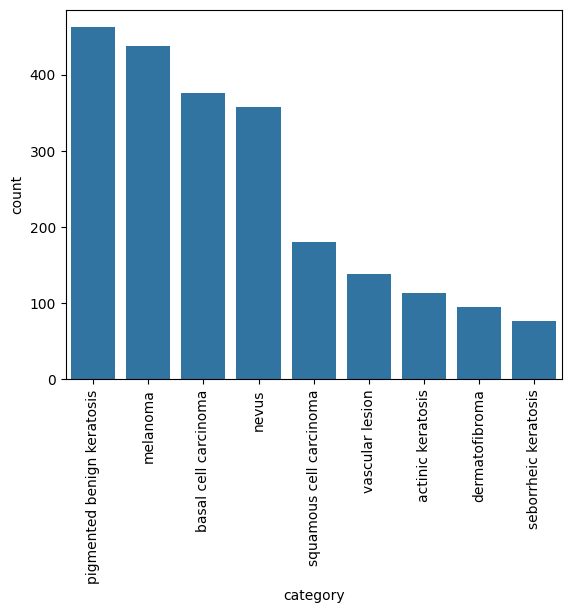

In [ ]:
# Lets create a dataframe containig counts of each type of class of images
dataCategoryCounts = {}
for className in class_names:
  dataCategoryCounts[className] = len(list(data_dir_train.glob(className + '/*.jpg')))
countData = pd.DataFrame(dataCategoryCounts.items(), columns=['category','count']).sort_values(by='count',ascending=False)
sns.barplot(data=countData, x='category',y='count')
plt.xticks(rotation=90)
plt.show()

- **seborrheic keratosis** class has less than 100 samples. **pigmented benign keratosis** and **melanoma** class has more than 400 samples. This clearly indicates the class imbalance. We need add more samples so that all classes has equal reprsentation in dataset.

#### Rectify the class imbalance


In [ ]:
# Lets add 500 samples for each class
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) + '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNNAssignment/SkinCancerDetection/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA300496090>: 100%|██████████| 500/500 [00:22<00:00, 22.55 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNNAssignment/SkinCancerDetection/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA2F9C9E6D0>: 100%|██████████| 500/500 [00:24<00:00, 20.63 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNNAssignment/SkinCancerDetection/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA2FBF15FD0>: 100%|██████████| 500/500 [00:22<00:00, 21.77 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNNAssignment/SkinCancerDetection/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EA2F9C74950>: 100%|██████████| 500/500 [01:46<00:00,  4.68 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNNAssignment/SkinCancerDetection/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7EA2FBFC3B90>: 100%|██████████| 500/500 [01:30<00:00,  5.50 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNNAssignment/SkinCancerDetection/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA2FBF7CFD0>: 100%|██████████| 500/500 [00:24<00:00, 20.67 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNNAssignment/SkinCancerDetection/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EA2F9DF5010>: 100%|██████████| 500/500 [00:46<00:00, 10.85 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNNAssignment/SkinCancerDetection/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA2FBF03550>: 100%|██████████| 500/500 [00:21<00:00, 23.18 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNNAssignment/SkinCancerDetection/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA2F9C9E6D0>: 100%|██████████| 500/500 [00:22<00:00, 21.90 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
# Lets verify the image count for augmented sample images
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])


In [ ]:
df2['Label'].value_counts()

,count
Label,
actinic keratosis,500
vascular lesion,500
pigmented benign keratosis,500
seborrheic keratosis,500
melanoma,500
nevus,500
dermatofibroma,500
basal cell carcinoma,500
squamous cell carcinoma,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [ ]:
# Load the dataset with new data
train_ds, val_ds, class_names,num_classes = load_datasets(data_dir_train,data_dir_test)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [ ]:
# Creating new model with batch normalization layers
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16,(3,3), activation='relu', padding='same'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32,(3,3), activation='relu', padding='same'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Compile model (Choose optimizer and loss function appropriately)

In [ ]:
# Compile model with batch normalization
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 64800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │       8,294,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,300,969 (31.67 MB)

 Trainable params: 8,300,873 (31.67 MB)

 Non-trainable params: 96 (384.00 B)

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.2326 - loss: 7.5547 - val_accuracy: 0.0906 - val_loss: 44.0050
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.2578 - loss: 2.0099 - val_accuracy: 0.2294 - val_loss: 5.6256
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.3232 - loss: 1.7754 - val_accuracy: 0.3148 - val_loss: 2.4180
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.3531 - loss: 1.6693 - val_accuracy: 0.3207 - val_loss: 1.8673
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.3702 - loss: 1.5926 - val_accuracy: 0.3972 - val_loss: 1.5065
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.4187 - loss: 1.4914 - val_accuracy: 0.3697 - val_loss: 1.5360
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.4297 - loss: 1.4302 - val_accuracy: 0.4254 - val_loss: 1.4652
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.4611 - loss: 1.3450 - val_acc

#### **Todo:**  Visualize the model results

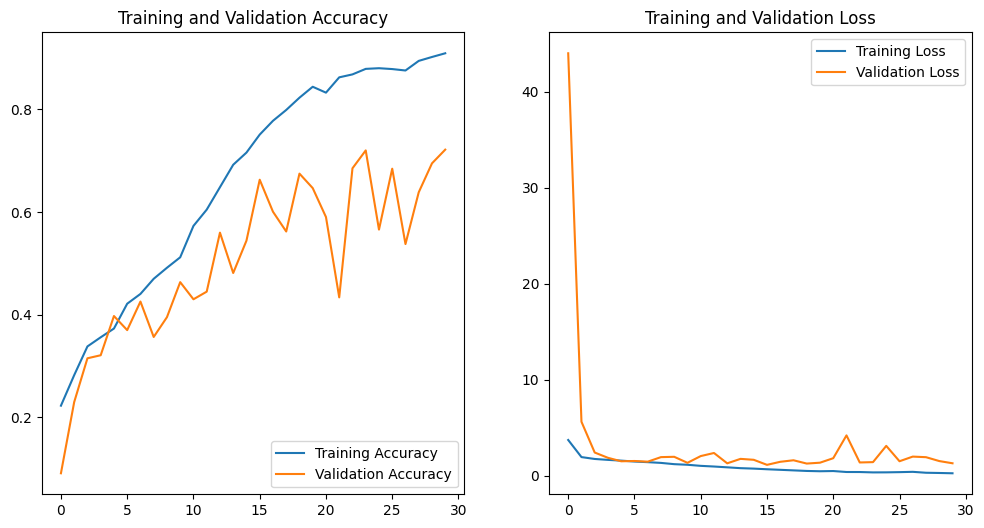

In [ ]:
# Visualize the training results
visualize_history(history,epochs)

- Training accuracy is evaluated to 90%
- Validation accuracy is evaludated to 72%
- There are several spikes in validation accuracy
- Due to batch normalization training accuracy increased but validation accuracy is not increasing. This is an evidence of overfitting

- Lets try removing batch normalization



In [ ]:
# Create a new model by removing batch normalization
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Conv2D(16,(3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Conv2D(32,(3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])


In [ ]:
# Compile model without batch normalization
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 64800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │       8,294,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,300,777 (31.66 MB)

 Trainable params: 8,300,777 (31.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 30
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.1975 - loss: 3.5873 - val_accuracy: 0.4313 - val_loss: 1.5558
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.4138 - loss: 1.5836 - val_accuracy: 0.4402 - val_loss: 1.4148
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.4450 - loss: 1.4725 - val_accuracy: 0.4410 - val_loss: 1.4480
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.4639 - loss: 1.4074 - val_accuracy: 0.5293 - val_loss: 1.3161
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.4969 - loss: 1.3350 - val_accuracy: 0.4640 - val_loss: 1.3743
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.5079 - loss: 1.2902 - val_accuracy: 0.5568 - val_loss: 1.1692
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.5548 - loss: 1.1902 - val_accuracy: 0.5598 - val_loss: 1.1670
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.5489 - loss: 1.1917 - val_accu

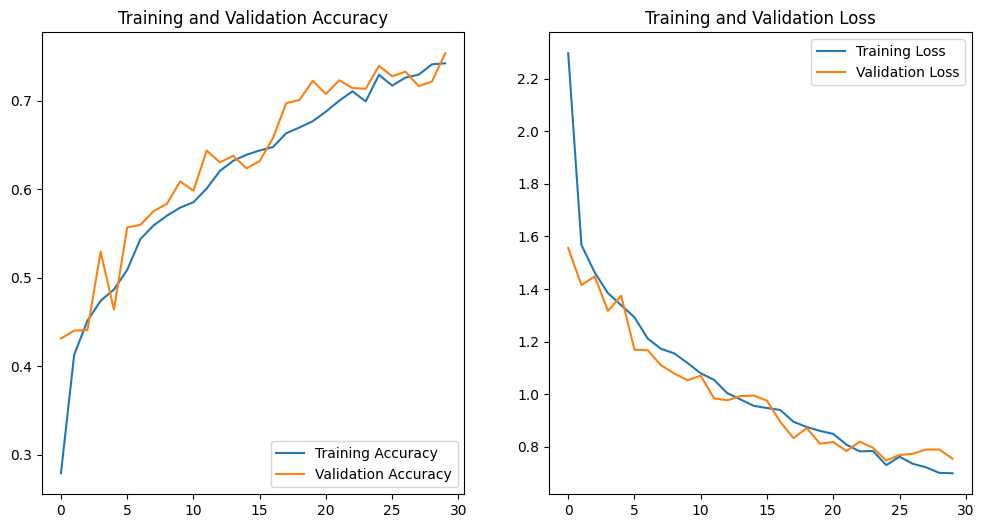

In [ ]:
# Visualize the training results
visualize_history(history,epochs)

- Training accuracy is evaluated t0 75%
- Validation accuracy is evaluated to 72%
- Now our model seemed to be learned well, validation accuracy is very near to training accuacy
- However there is a scope of imporoving training and validation accuracy

### Adding more augmented samples to learn generalised patterns

In [ ]:
# Lets add 200 more augmented images for better tuning the model
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) + '/' + i)
    p.rotate(probability=0.6, max_left_rotation=10, max_right_rotation=10)
    p.zoom(0.15,min_factor=1.1, max_factor=1.5)
    p.sample(200) ## We are adding 200 samples per class

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNNAssignment/SkinCancerDetection/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA2F9CC6090>: 100%|██████████| 200/200 [00:07<00:00, 27.02 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNNAssignment/SkinCancerDetection/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA308490750>: 100%|██████████| 200/200 [00:07<00:00, 26.25 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNNAssignment/SkinCancerDetection/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA300E84050>: 100%|██████████| 200/200 [00:09<00:00, 20.86 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNNAssignment/SkinCancerDetection/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7EA2F9DEC190>: 100%|██████████| 200/200 [00:34<00:00,  5.79 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNNAssignment/SkinCancerDetection/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x7EA300414890>: 100%|██████████| 200/200 [00:35<00:00,  5.66 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNNAssignment/SkinCancerDetection/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA2FBE08ED0>: 100%|██████████| 200/200 [00:08<00:00, 22.48 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNNAssignment/SkinCancerDetection/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7EA30842C390>: 100%|██████████| 200/200 [00:16<00:00, 12.17 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNNAssignment/SkinCancerDetection/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EA2FBD5CD90>: 100%|██████████| 200/200 [00:09<00:00, 21.09 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNNAssignment/SkinCancerDetection/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EA2FBF17910>: 100%|██████████| 200/200 [00:10<00:00, 18.19 Samples/s]


In [ ]:
# Load dataset again with new samples
train_ds, val_ds, class_names,num_classes = load_datasets(data_dir_train,data_dir_test)

Found 8539 files belonging to 9 classes.
Using 6832 files for training.
Found 8539 files belonging to 9 classes.
Using 1707 files for validation.


In [ ]:
# lets retrain our model with more data
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Conv2D(16,(3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Conv2D(32,(3,3), activation='relu', padding='same'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])


In [ ]:
# Compile model without batch normalization
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 64800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │       8,294,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,300,777 (31.66 MB)

 Trainable params: 8,300,777 (31.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# lets retrain our model with more epochs
epochs = 40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
214/214 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.2043 - loss: 3.1444 - val_accuracy: 0.3972 - val_loss: 1.6042
Epoch 2/40
214/214 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.4134 - loss: 1.5268 - val_accuracy: 0.4704 - val_loss: 1.4015
Epoch 3/40
214/214 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.4619 - loss: 1.4146 - val_accuracy: 0.4722 - val_loss: 1.3551
Epoch 4/40
214/214 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.4905 - loss: 1.3240 - val_accuracy: 0.4985 - val_loss: 1.2979
Epoch 5/40
214/214 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.5312 - loss: 1.2404 - val_accuracy: 0.5190 - val_loss: 1.3006
Epoch 6/40
214/214 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.5290 - loss: 1.2231 - val_accuracy: 0.5688 - val_loss: 1.1736
Epoch 7/40
214/214 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.5630 - loss: 1.1514 - val_accuracy: 0.5419 - val_loss: 1.2078
Epoch 8/40
214/214 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.5812 - loss: 1.1060 - val_accu

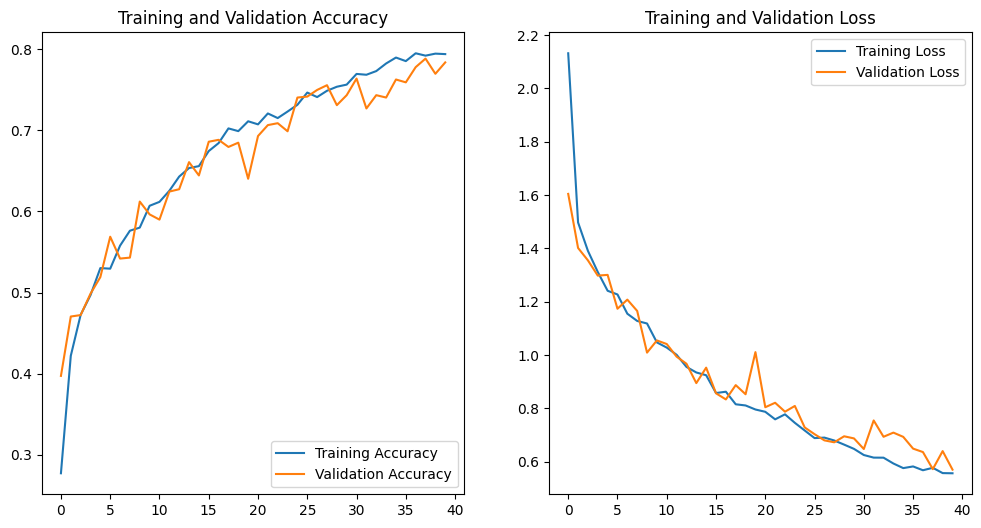

In [ ]:
# Visualize the training results
visualize_history(history,epochs)

- Training accuracy is evaluated t0 80%
- Validation accuracy is evaluated to 78%
- By adding more samples and increasing number of epochs model's training and validation accuracy is improved by 6%
- Now our model seemed to be improved, validation accuracy is very near to training accuacy